In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [14]:
maxEvents = 120000

debug = 0

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.4, 1.6, 1.8, 2.0, 2.15, 2.5)
eta_bins = eta_bins[::-1]

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def analysis(verbose=1):
  tree = load_pgun()
  
  out_phis = {}
  out_thetas = {}

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_phi_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_array.shape):
      sector_phi_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      endsec = find_endsec(hit.endcap, hit.sector)
      assert(hit.emtf_phi < 5040)  # 84*60
      
      sector_cnt_array[endsec] += 1
      sector_phi_array[endsec].append(hit.emtf_phi)
    
    best_sector = np.argmax(sector_cnt_array)
    
    part_phi = np.rad2deg(part.phi)
    if best_sector == 2 or best_sector == 8:
      if part_phi < 0.:
        part_phi += 360.
    out_phis.setdefault(best_sector, []).append(part_phi)
    
    part_zone = find_eta_bin(part.eta)
    for ihit, hit in enumerate(evt.hits):
      endsec = find_endsec(hit.endcap, hit.sector)
      if endsec == best_sector:
        out_thetas.setdefault((part_zone, hit.type), []).append(hit.emtf_theta)
    
  return (out_phis, out_thetas)

In [15]:
# Run analysis

(out_phis, out_thetas) = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000
Processing event: 20000
Processing event: 21000
Processing event: 22000
Processing event: 23000
Processing event: 24000
Processing event: 25000
Processing event: 26000
Processing event: 27000
Processing event: 28000
Processing event: 29000
Processing event: 30000
Processing event: 31000
Processing event: 32000
Processing event: 33000
Processing event: 34000
Processing event: 35000
Processing event: 36000
Processing event: 37000
Processing event: 38000
Processin

0 [356.3214847977957, 39.17238346283297, 82.02328212787023]


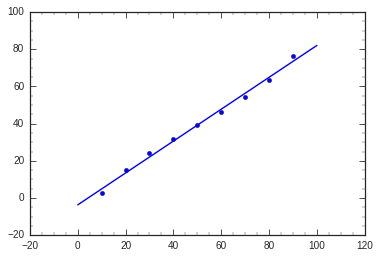

1 [59.5897578546404, 100.93879019989346, 142.28782254514653]


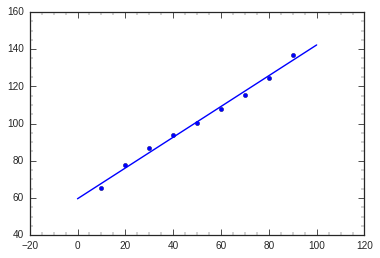

2 [119.34361591181677, 161.26764587284197, 203.19167583386718]


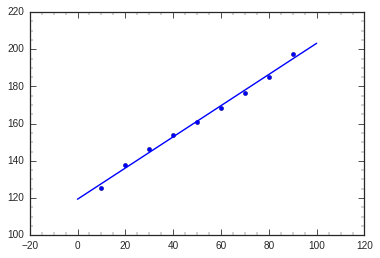

3 [185.74301236407229, 228.65532679523628, 271.56764122640027]


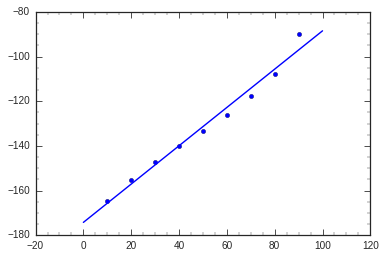

4 [239.91636583235962, 281.51079053895546, 323.10521524555134]


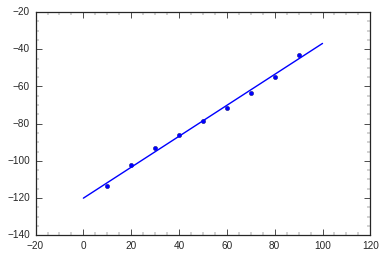

5 [299.0564062522102, 338.2644931984655, 17.472580144720766]


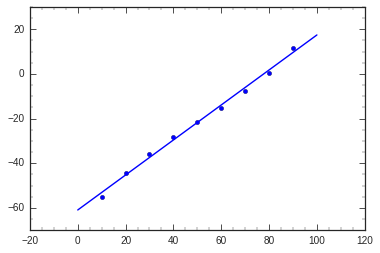

6 [356.36856958907197, 38.757219862562096, 81.14587013605222]


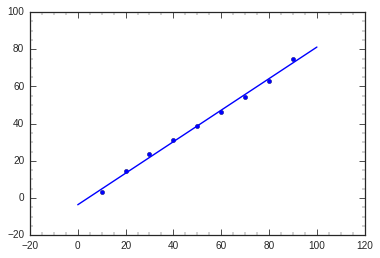

7 [59.832439294928875, 101.27283737316189, 142.7132354513949]


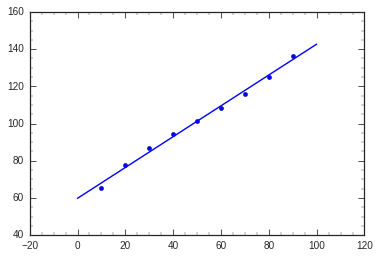

8 [119.71271493288683, 161.09802374073806, 202.4833325485893]


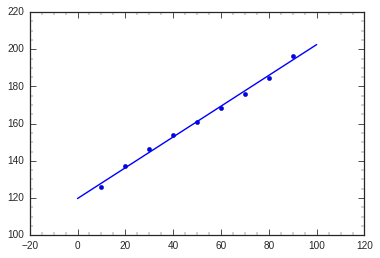

9 [184.17632148252858, 227.82340740170798, 271.4704933208874]


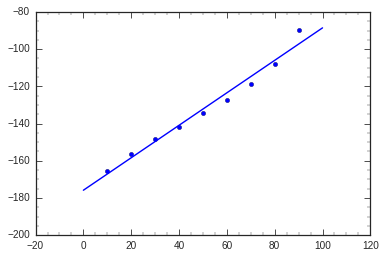

10 [240.25952193563268, 281.1385973663005, 322.0176727969682]


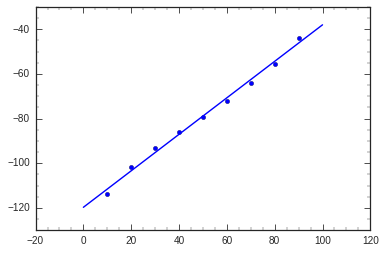

11 [299.2265436138831, 338.4529022224133, 17.67926083094352]


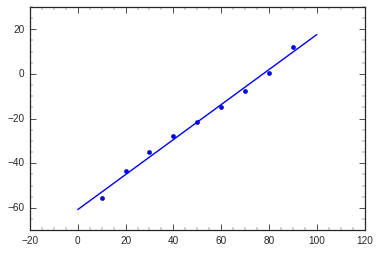

In [16]:
# Results

if True:
  from sklearn.linear_model import LinearRegression
  
  for endsec in xrange(12):
    plt.figure()
    
    phis = out_phis[endsec]
    p = np.array([10,20,30,40,50,60,70,80,90])
    p100 = np.array([0,10,20,30,40,50,60,70,80,90,100])
    pp = np.percentile(phis, p, overwrite_input=True)
    #print endsec, len(phis), pp
    
    lr = LinearRegression()
    lr.fit(p[:,np.newaxis], pp)
    a, b = lr.intercept_, lr.coef_[0]
    fun = lambda x: x if x >= 0. else x + 360.
    print endsec, map(fun, (a, a + b*50, a + b*100))
    
    plt.scatter(p, pp)
    plt.plot(p100, lr.predict(p100[:,np.newaxis]))
    plt.show()

In [19]:
# Results

if True:
  
  for zone in xrange(6):
    for hit_type in xrange(1,5):
      if (zone,hit_type) in out_thetas:
        thetas = out_thetas[(zone,hit_type)]
        p = np.array([1,1.5,2,3,4,5,10,25,50,75,95,96,97,98,98.5,99])
        pp = np.percentile(thetas, p, overwrite_input=True)
        print (zone, hit_type), len(thetas), pp


(0, 1) 93597 [ 5.  5.  5.  5.  6.  6.  7.  8. 11. 13. 16. 16. 16. 17. 17. 17.]
(0, 2) 50199 [ 4.  4.  4.  4.  4.  4.  4.  8. 12. 12. 16. 16. 20. 20. 20. 20.]
(0, 3) 32191 [ 7.  7.  7.  7.  7.  7.  7.  7. 12. 13. 18. 18. 18. 18. 19. 19.]
(0, 4) 26545 [ 4.  5.  5.  5.  5.  6.  7.  8. 11. 13. 17. 17. 17. 17. 17. 17.]
(1, 1) 54254 [12. 12. 13. 14. 14. 14. 16. 18. 19. 21. 24. 24. 24. 24. 25. 25.]
(1, 2) 26967 [12. 12. 12. 12. 12. 12. 12. 16. 20. 24. 24. 24. 24. 24. 24. 24.]
(1, 3) 34641 [13. 17. 17. 17. 17. 17. 17. 18. 19. 21. 24. 24. 24. 25. 26. 26.]
(1, 4) 13838 [17. 17. 17. 17. 17. 17. 17. 17. 20. 22. 23. 23. 23. 23. 23. 23.]
(2, 1) 72865 [17. 18. 19. 20. 20. 21. 23. 25. 28. 31. 34. 35. 35. 35. 35. 36.]
(2, 2) 33696 [12. 16. 16. 16. 20. 20. 24. 24. 28. 32. 36. 36. 36. 36. 36. 36.]
(2, 3) 44340 [19. 19. 21. 23. 23. 23. 24. 26. 29. 32. 35. 35. 35. 35. 37. 37.]
(2, 4) 1598 [22. 22. 22. 22. 22. 22. 22. 22. 22. 22. 23. 23. 23. 23. 23. 23.]
(3, 1) 61444 [26. 26. 27. 29. 29. 30. 33. 36. 40. 45.